# Explore the size vs. accuracy trade-off for synthetic data

In this exercise, we are going to explore the relationship between the number of training samples, that are being used for the synthesis, and the corresponding accuracy of the generated synthetic data. We expect to see a higher accuracy for an increasing number of training samples. But along with a larger number of training samples, we will also see an increase in computational effort, i.e. overall runtime.

<img src='https://raw.githubusercontent.com/mostly-ai/mostly-tutorials/dev/size-vs-accuracy/size-vs-accuracy.png' width="600px"/>

Note, that we shall not expect synthetic data to perfectly match the original data. This would only be satisfied by a copy of the data, which obviously would neither satisfy any privacy requirements nor would provide any novel samples. That being said, we shall expect that due to sampling variance the synthetic data can deviate. Ideally, just as much, and not more than the deviation that we would observe by analyzing an actual holdout data.

## Synthesize Data via MOSTLY AI

For this tutorial, we will be using the same UCI Adult Income [[1](#refs)] dataset, that was used in the Train-Synthetic-Test-Real tutorial. Thus, we have in total 48,842 records across 15 attributes, and will be using up to 39,073 (=80%) of those records for the creation of Generators.

The following code creates different Generators, each time with a different number of maximum training samples. E.g. 100, 400, 1,600, 6,400, 25,600. Feel free to adjust these numbers as you are experimenting. Subsequently different Synthetic Datasets based on the Generators are created.

Please replace `INSERT_YOUR_API_KEY` with your API KEY before executing the code below and make sure you have all the required packages installed.

In [3]:
#!pip install mostlyai scikit-learn seaborn lightgbm

from mostlyai import MostlyAI
import pandas as pd
from sklearn.model_selection import train_test_split

# fetch original data
df = pd.read_csv('https://github.com/mostly-ai/public-demo-data/raw/dev/census/census.csv.gz')
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [4]:
# split into training and validation
df_trn, df_hol = train_test_split(df, test_size=0.2, random_state=1)

print(f'training data with {df_trn.shape[0]:,} records and {df_trn.shape[1]} attributes')
print(f'holdout data with {df_hol.shape[0]:,} records and {df_hol.shape[1]} attributes')

training data with 39,073 records and 15 attributes
holdout data with 9,769 records and 15 attributes


In [5]:
# initialize client
mostly = MostlyAI(
    api_key='INSERT_YOUR_API_KEY' 
)

# create generators with different sample sizes
g_100 = mostly.train(data=df_trn.sample(100), name="census_100")
g_400 = mostly.train(data=df_trn.sample(400), name="census_400")
g_1600 = mostly.train(data=df_trn.sample(1600), name="census_1600")
g_6400 = mostly.train(data=df_trn.sample(6400), name="census_6400")
g_25600 = mostly.train(data=df_trn.sample(25600), name="census_25600")

# Generate synthetic data
synthetic_data = {
    "syn_100": mostly.generate(g_100, size=10_000).data(),
    "syn_400": mostly.generate(g_400, size=10_000).data(),
    "syn_1600": mostly.generate(g_1600, size=10_000).data(),
    "syn_6400": mostly.generate(g_6400, size=10_000).data(),
    "syn_25600": mostly.generate(g_25600, size=10_000).data()
}

Created generator ]8;id=971416;https://app.mostly.ai/d/generators/e94d0010-10c8-4aaa-8a0e-72f580291286\e94d0010-10c8-4aaa-8a0e-72f580291286]8;;\

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Share it so others can do the same.

Created generator ]8;id=722728;https://app.mostly.ai/d/generators/9db17d72-5ccf-4281-be82-9074a5a6b9c8\9db17d72-5ccf-4281-be82-9074a5a6b9c8]8;;\

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Share it so others can do the same.

Created generator ]8;id=286808;https://app.mostly.ai/d/generators/2a5143b9-aee3-4442-885e-76c75a6819d6\2a5143b9-aee3-4442-885e-76c75a6819d6]8;;\

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Share it so others can do the same.

Created generator ]8;id=421923;https://app.mostly.ai/d/generators/45cb1634-b7c5-439c-b926-0c7720d7585e\45cb1634-b7c5-439c-b926-0c7720d7585e]8;;\

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Share it so others can do the same.

Created generator ]8;id=34889;https://app.mostly.ai/d/generators/85853a7d-3fee-4c79-a7ee-d86a04409851\85853a7d-3fee-4c79-a7ee-d86a04409851]8;;\

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Share it so others can do the same.

Created synthetic dataset ]8;id=798027;https://app.mostly.ai/d/synthetic-datasets/3fe6809a-2175-450c-a1a1-631945a41256\3fe6809a-2175-450c-a1a1-631945a41256]8;;\ with generator ]8;id=411604;https://app.mostly.ai/d/generators/e94d0010-10c8-4aaa-8a0e-72f580291286\e94d0010-10c8-4aaa-8a0e-72f580291286]8;;\

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Share it so others can do the same.

Created synthetic dataset ]8;id=43968;https://app.mostly.ai/d/synthetic-datasets/656d11b6-dda2-4e77-8732-0457b62a62c9\656d11b6-dda2-4e77-8732-0457b62a62c9]8;;\ with generator ]8;id=225418;https://app.mostly.ai/d/generators/9db17d72-5ccf-4281-be82-9074a5a6b9c8\9db17d72-5ccf-4281-be82-9074a5a6b9c8]8;;\

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Share it so others can do the same.

Created synthetic dataset ]8;id=903342;https://app.mostly.ai/d/synthetic-datasets/f0a4e833-5968-4191-90dd-0be7fd86967d\f0a4e833-5968-4191-90dd-0be7fd86967d]8;;\ with generator ]8;id=590560;https://app.mostly.ai/d/generators/2a5143b9-aee3-4442-885e-76c75a6819d6\2a5143b9-aee3-4442-885e-76c75a6819d6]8;;\

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Share it so others can do the same.

Created synthetic dataset ]8;id=369747;https://app.mostly.ai/d/synthetic-datasets/849c9b18-a043-4793-85a9-ef13d9c4646d\849c9b18-a043-4793-85a9-ef13d9c4646d]8;;\ with generator ]8;id=127790;https://app.mostly.ai/d/generators/45cb1634-b7c5-439c-b926-0c7720d7585e\45cb1634-b7c5-439c-b926-0c7720d7585e]8;;\

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Share it so others can do the same.

Created synthetic dataset ]8;id=648062;https://app.mostly.ai/d/synthetic-datasets/60fce22d-92d7-423a-b575-ba2f9e001906\60fce22d-92d7-423a-b575-ba2f9e001906]8;;\ with generator ]8;id=585602;https://app.mostly.ai/d/generators/85853a7d-3fee-4c79-a7ee-d86a04409851\85853a7d-3fee-4c79-a7ee-d86a04409851]8;;\

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Share it so others can do the same.

Now go to the UI of MOSTLY AI, look at the created Generators and take notes of the reported runtime of each training step, and update the following DataFrame accordingly. The overall accuracy of the created Generators is loaded automatically.

In [6]:
results = pd.DataFrame([
    {'samples': 100, 'accuracy': g_100.accuracy, 'trainingtime': 2},
    {'samples': 400, 'accuracy': g_400.accuracy, 'trainingtime': 5},
    {'samples': 1600, 'accuracy': g_1600.accuracy, 'trainingtime': 24},
    {'samples': 6400, 'accuracy': g_6400.accuracy, 'trainingtime': 56},
    {'samples': 25600, 'accuracy': g_25600.accuracy, 'trainingtime': 73},
])
results

,samples,accuracy,trainingtime
0,100,0.524,2
1,400,0.695,5
2,1600,0.910,24
3,6400,0.965,56
4,25600,0.978,73


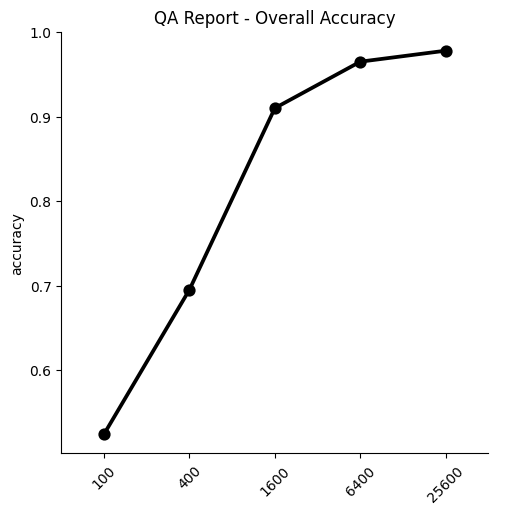

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(data=results, y='accuracy', x='samples', kind='point', color='black')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('QA Report - Overall Accuracy')
plt.show()

## Explore Synthetic Data

Show 3 randomly sampled synthetic records for each of the datasets. Note, that you can execute the following cell multiple times, to see different samples. 

In [10]:
for generator, df in synthetic_data.items():
    print("===", generator, "===")
    display(df.sample(n=3))

=== syn_100 ===


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
4341,36,_RARE_,208618,_RARE_,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,58,United-States,<=50K
8310,45,Private,301601,HS-grad,13,Married-civ-spouse,Farming-fishing,Not-in-family,White,Male,3444,0,41,United-States,<=50K
8549,61,_RARE_,190677,Assoc-voc,5,Divorced,Sales,Own-child,White,Female,3338,0,49,United-States,<=50K


=== syn_400 ===


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
2937,17,Local-gov,527748,11th,3,Married-civ-spouse,Prof-specialty,Not-in-family,Black,Female,0,0,20,United-States,<=50K
3197,20,Private,101027,Assoc-voc,3,_RARE_,Handlers-cleaners,Not-in-family,White,Female,0,0,30,United-States,<=50K
1967,67,Local-gov,244519,9th,14,Separated,Farming-fishing,Own-child,Black,Male,1430,0,45,?,>50K


=== syn_1600 ===


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
2812,29,?,228781,5th-6th,6,Separated,?,Other-relative,White,Male,0,0,40,United-States,<=50K
8234,41,?,56359,7th-8th,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,36,United-States,>50K
9367,19,State-gov,151649,Some-college,10,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,60,United-States,>50K


=== syn_6400 ===


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
4456,46,Private,199511,Some-college,10,Divorced,Transport-moving,Unmarried,Black,Female,0,0,43,United-States,<=50K
1769,41,Private,27961,HS-grad,9,Separated,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K
9241,37,Self-emp-inc,97375,12th,8,Married-civ-spouse,?,Husband,White,Male,0,0,72,United-States,<=50K


=== syn_25600 ===


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
142,66,Private,50817,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States,<=50K
3264,33,Local-gov,94194,Some-college,10,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,46,United-States,<=50K
9670,41,Private,112803,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,50,United-States,<=50K


## Quality Assessment

Concatenate all datasets together to ease comparions across these.

In [13]:
# combine synthetics
df = pd.concat([d.assign(split=k) for k, d in synthetic_data.items()], axis=0)
df['split'] = pd.Categorical(df['split'], categories=df["split"].unique())
df.insert(0, 'split', df.pop('split'))
# combine synthetics and original
dataset = synthetic_data | {'training': df_trn, 'holdout': df_hol}
df_all = pd.concat([d.assign(split=k) for k, d in dataset.items()], axis=0)
df_all['split'] = pd.Categorical(df_all['split'], categories=df_all["split"].unique())
df_all.insert(0, 'split', df_all.pop('split'))

### Compare single statistic

The more training samples have been used for the synthesis, the closer the synthetic distributions are expected to be to the original ones.

Note, that we can also see deviations within statistics between the target and the holdout data. This is expected due to the sampling variance. The smaller the dataset, the larger the sampling variance will be.

#### Average number of Hours-Per-Week, split by Gender

In [14]:
stats = df_all.groupby(['split', 'sex'], observed=True)['hours_per_week'].mean().round(1).to_frame().reset_index(drop=False)
stats = stats.pivot_table(index='split', columns=['sex'], observed=True).reset_index(drop=False)
stats

split hours_per_week      
sex                    Female  Male
0      syn_100           44.6  44.4
1      syn_400           40.4  41.0
2     syn_1600           37.6  41.8
3     syn_6400           37.2  42.8
4    syn_25600           36.6  42.3
5     training           36.5  42.5
6      holdout           36.1  42.3

#### Average Age, split by Marital Status

In [15]:
stats = df_all.groupby(['split', 'marital_status'], observed=True)['age'].mean().round().to_frame().reset_index(drop=False)
stats = stats.loc[~stats['marital_status'].isin(['_RARE_', 'Married-AF-spouse', 'Married-spouse-absent', 'Separated'])]
stats = stats.pivot_table(index='split', columns='marital_status', values='age', observed=True).reset_index()
stats

marital_status,split,Divorced,Married-civ-spouse,Never-married,Widowed
0,syn_100,45.0,45.0,45.0,<NA>
1,syn_400,44.0,45.0,43.0,<NA>
2,syn_1600,44.0,45.0,39.0,44.0
3,syn_6400,43.0,43.0,30.0,54.0
4,syn_25600,43.0,43.0,29.0,58.0
5,training,43.0,43.0,28.0,60.0
6,holdout,43.0,43.0,28.0,58.0


#### Age distribution, split by Income

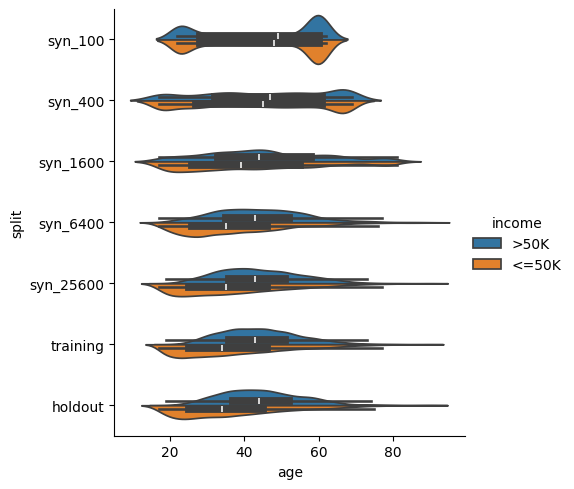

In [16]:
sns.catplot(data=df_all, x='age', y='split', hue='income', kind='violin', split=True)
plt.show()

### Check rule adherence

The original data has a 1:1 relationship between `education` and `education_num`. Let's check in how many cases the generated synthetic data has correctly retained that specific rule between these two columns.

In [17]:
# display unique combinations of `education` and `education_num`
df_trn[['education', 'education_num']].drop_duplicates().sort_values('education_num').reset_index(drop=True)

,education,education_num
0,Preschool,1
1,1st-4th,2
2,5th-6th,3
3,7th-8th,4
4,9th,5
5,10th,6
6,11th,7
7,12th,8
8,HS-grad,9
9,Some-college,10


In [18]:
# Convert `education` to Categorical with proper sort order
df['education'] = pd.Categorical(df['education'], categories=df_trn.sort_values('education_num')['education'].unique())

# Calculate the correct match, explicitly excluding the group keys from the apply operation
stats = df.groupby('split', observed=True).apply(
    lambda x: ((x['education'].cat.codes + 1) == x['education_num']).mean()
).reset_index(name='matches')

stats


,split,matches
0,syn_100,0.1058
1,syn_400,0.0834
2,syn_1600,0.6915
3,syn_6400,0.9940
4,syn_25600,0.9999


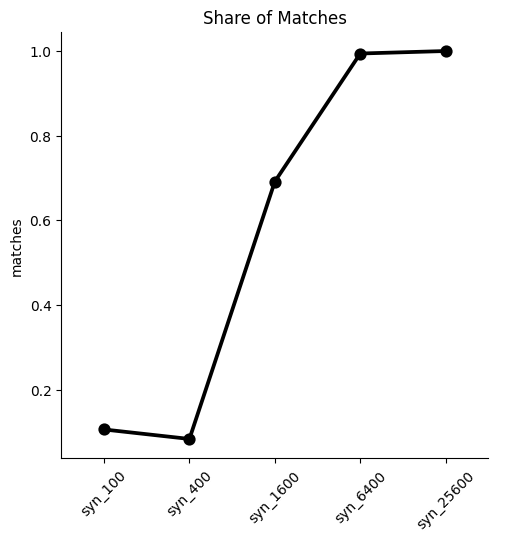

In [19]:
sns.catplot(data=stats, y='matches', x='split', kind='point', color='black')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Share of Matches')
plt.show()

### Compare ML performance via TSTR

Let's perform a Train-Synthetic-Test-Real evaluation via a downstream LightGBM classifier.

In [20]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

target_col = 'income'
target_val = '>50K'

# prepare data, and split into features `X` and target `y`
def prepare_xy(df: pd.DataFrame):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

# train ML model with early stopping
def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

# apply ML Model to some holdout data, report key metrics, and visualize scores
def evaluate_model(model, hol):
    X_hol, y_hol = prepare_xy(hol)
    probs = model.predict(X_hol)
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_hol, probs)
    return auc

def train_and_evaluate(df):
    X, y = prepare_xy(df)
    model = train_model(X, y)
    auc = evaluate_model(model, df_hol)
    return auc

import warnings
warnings.filterwarnings('ignore')

In [22]:
aucs = {k: train_and_evaluate(df) for k, df in synthetic_data.items()}
aucs = pd.Series(aucs).round(3).to_frame('auc').reset_index()

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.511158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.642214
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.869864
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.897315
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.924477


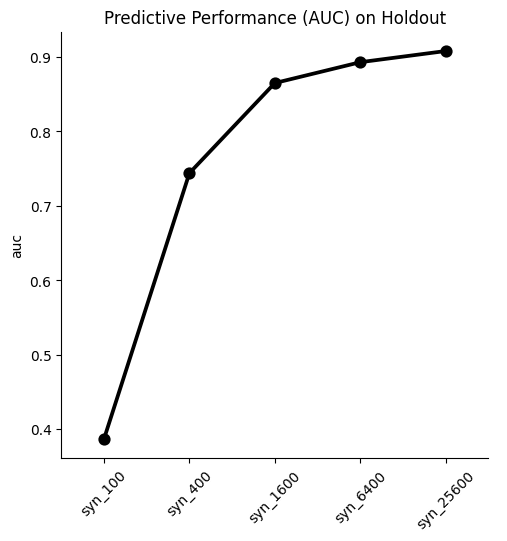

In [23]:
sns.catplot(data=aucs, y='auc', x='index', kind='point', color='black')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Predictive Performance (AUC) on Holdout')
plt.show()

## Conclusion

For the given dataset and the given synthesizer we can indeed observe an increase in synthetic data quality with a growing number of training samples. This can be measured with respect to accuracy, as well as ML utility.

As we can also observe, is that a holdout dataset will exhibit deviations from the training data due to the sampling noise as well. With the holdout data being actual data, that hasn't been seen before, it serves us as a north star in terms of maximum acchievable accuracy for synthetic data. See our paper on this subject [[2](#refs)].

## Further exercises

In addition to walking through the above instructions, we suggest..
* to limit model training to a few epochs, e.g. by setting the maximum number of epochs to 1 or 5 and study its impact on runtime and quality.
* to synthesize with different model_sizes: Small, Medium and Large, and study its impact on runtime and quality.
* to synthesize with the same settings several times, and with that study the variability in quality across several runs.
* to calculate and compare your own statistics, and then compare the deviations between synthetic and training. The deviations between holdout and training can serve as a benchmark .

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://www.frontiersin.org/articles/10.3389/fdata.2021.679939/full